In [15]:
import gc
import os
import json
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
warnings.filterwarnings('ignore')
import json


In [66]:
pd.set_option('display.max_columns', None)

https://beerys.github.io/CaltechCameraTraps/   - link to data description

http://lila.science/datasets/caltech-camera-traps
This data set contains 243,100 images from 140 camera locations in the Southwestern United States, with labels for 21 animal categories (plus empty), primarily at the species level (for example, the most common labels are opossum, raccoon, and coyote), and approximately 66,000 bounding box annotations. Approximately 70% of images are labeled as empty.

In [13]:
PATH="cct_images/"
os.listdir(PATH)[:10]


['5971f954-23d2-11e8-a6a3-ec086b02610b.jpg',
 '59862578-23d2-11e8-a6a3-ec086b02610b.jpg',
 '59da8b91-23d2-11e8-a6a3-ec086b02610b.jpg',
 '58a8a3c5-23d2-11e8-a6a3-ec086b02610b.jpg',
 '595add68-23d2-11e8-a6a3-ec086b02610b.jpg',
 '58e40ea5-23d2-11e8-a6a3-ec086b02610b.jpg',
 '5938c3b3-23d2-11e8-a6a3-ec086b02610b.jpg',
 '599a5afa-23d2-11e8-a6a3-ec086b02610b.jpg',
 '586fdec2-23d2-11e8-a6a3-ec086b02610b.jpg',
 '58b9d795-23d2-11e8-a6a3-ec086b02610b.jpg']

## BOXES

In [20]:
#open json files  - BOXES
with open('caltech_bboxes_20200316.json') as f:
    data = f.read()
    boxes = json.loads(data)
    

In [22]:
boxes.keys()

dict_keys(['info', 'categories', 'annotations', 'images'])

In [23]:
boxes['info']

{'contributor': 'Sara Beery',
 'version': '20200316',
 'year': 2018,
 'date_created': '2019-09-23 06:59:06.304889',
 'description': 'Bounding box annotations for 63,025 images from Caltech Camera Traps, where the images only have one species label or are empty. Contains all annotations for CCT - 20, the 20-location dataset used in the ECCV18 paper "Recognition in Terra Incognita," as well as additional annotations collected by MS AI for Earth.'}

In [24]:
boxes['categories']

[{'id': 6, 'name': 'bobcat'},
 {'id': 1, 'name': 'opossum'},
 {'id': 30, 'name': 'empty'},
 {'id': 9, 'name': 'coyote'},
 {'id': 3, 'name': 'raccoon'},
 {'id': 11, 'name': 'bird'},
 {'id': 8, 'name': 'dog'},
 {'id': 16, 'name': 'cat'},
 {'id': 5, 'name': 'squirrel'},
 {'id': 10, 'name': 'rabbit'},
 {'id': 7, 'name': 'skunk'},
 {'id': 14, 'name': 'lizard'},
 {'id': 99, 'name': 'rodent'},
 {'id': 21, 'name': 'badger'},
 {'id': 34, 'name': 'deer'},
 {'id': 37, 'name': 'cow'},
 {'id': 33, 'name': 'car'},
 {'id': 51, 'name': 'fox'},
 {'id': 39, 'name': 'pig'},
 {'id': 40, 'name': 'mountain_lion'},
 {'id': 66, 'name': 'bat'},
 {'id': 97, 'name': 'insect'}]

In [29]:
#  22 framed objects 
len(boxes['categories'])

22

In [28]:
[obj['name'] for obj in boxes['categories']]

['bobcat',
 'opossum',
 'empty',
 'coyote',
 'raccoon',
 'bird',
 'dog',
 'cat',
 'squirrel',
 'rabbit',
 'skunk',
 'lizard',
 'rodent',
 'badger',
 'deer',
 'cow',
 'car',
 'fox',
 'pig',
 'mountain_lion',
 'bat',
 'insect']

With translations:
'ryś amerykański',  'opos',  'pusty',  'kojot',  'szop pracz',  'ptak',  'pies',  'kot',  'wiewiórka', 
'Królik',  'skunks',  'jaszczurka',  'gryzoń', 'borsuk',  'jeleń',  'krowa',  'samochód',  'lis',  'świnia',
'Lew górski',  'nietoperz','owad'

In [36]:
# number of annotations
len(boxes['annotations'])

65112

In [31]:
# 
boxes['annotations'][:2]

[{'image_id': '5998cfa4-23d2-11e8-a6a3-ec086b02610b',
  'id': '2a545520-cbf1-11e8-819c-970a9450cdbc',
  'bbox': [499.2, 711.68, 353.28000000000003, 199.67999999999995],
  'category_id': 1},
 {'image_id': '588a679f-23d2-11e8-a6a3-ec086b02610b',
  'id': '2a54562e-cbf1-11e8-819c-970a9450cdbc',
  'bbox': [985.6, 783.36, 368.64, 230.39999999999998],
  'category_id': 1}]

In [34]:
boxes['images'][:2]

[{'file_name': '5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg',
  'seq_id': '6f084ccc-5567-11e8-bc84-dca9047ef277',
  'height': 1494,
  'id': '5998cfa4-23d2-11e8-a6a3-ec086b02610b',
  'frame_num': 1,
  'width': 2048,
  'date_captured': '2011-05-13 23:43:18',
  'rights_holder': 'Justin Brown',
  'seq_num_frames': 3,
  'location': '33'},
 {'file_name': '588a679f-23d2-11e8-a6a3-ec086b02610b.jpg',
  'seq_id': '6f12067d-5567-11e8-b3c0-dca9047ef277',
  'height': 1494,
  'id': '588a679f-23d2-11e8-a6a3-ec086b02610b',
  'frame_num': 2,
  'width': 2048,
  'date_captured': '2012-03-17 03:48:44',
  'rights_holder': 'Justin Brown',
  'seq_num_frames': 3,
  'location': '115'}]

In [38]:
# number of images 
len(boxes['images'])

63025

In [40]:
# there are photos with more than one object
len(boxes['annotations'])-len(boxes['images'])

2087

In [98]:
im_b = pd.DataFrame(boxes['images'])
im_b.columns=['file_name', 'seq_id', 'height', 'image_id', 'frame_num', 'width','date_captured', 'rights_holder', 'seq_num_frames', 'location']
an_b = pd.DataFrame(boxes['annotations'])
an_b.head(1)

,image_id,id,bbox,category_id
0,5998cfa4-23d2-11e8-a6a3-ec086b02610b,2a545520-cbf1-11e8-819c-970a9450cdbc,"[499.2, 711.68, 353.28000000000003, 199.679999...",1


In [99]:
im_b.columns

Index(['file_name', 'seq_id', 'height', 'image_id', 'frame_num', 'width',
       'date_captured', 'rights_holder', 'seq_num_frames', 'location'],
      dtype='object')

In [100]:
boxes_df=im_b.merge(an_b, how='inner', left_on='image_id', right_on='image_id' )
boxes_df.head(3)

,file_name,seq_id,height,image_id,frame_num,width,date_captured,rights_holder,seq_num_frames,location,id,bbox,category_id
0,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,6f084ccc-5567-11e8-bc84-dca9047ef277,1494,5998cfa4-23d2-11e8-a6a3-ec086b02610b,1,2048,2011-05-13 23:43:18,Justin Brown,3,33,2a545520-cbf1-11e8-819c-970a9450cdbc,"[499.2, 711.68, 353.28000000000003, 199.679999...",1
1,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,6f12067d-5567-11e8-b3c0-dca9047ef277,1494,588a679f-23d2-11e8-a6a3-ec086b02610b,2,2048,2012-03-17 03:48:44,Justin Brown,3,115,2a54562e-cbf1-11e8-819c-970a9450cdbc,"[985.6, 783.36, 368.64, 230.39999999999998]",1
2,593d68d7-23d2-11e8-a6a3-ec086b02610b.jpg,6f0f6778-5567-11e8-b5d2-dca9047ef277,1494,593d68d7-23d2-11e8-a6a3-ec086b02610b,3,2048,2011-06-28 15:29:42,Justin Brown,3,90,2a54599e-cbf1-11e8-819c-970a9450cdbc,"[1779.2, 407.04, 61.440000000000055, 84.480000...",5


## splits???

In [41]:
with open('CaltechCameraTrapsSplits_v0.json') as f:
    data = f.read()
    splits = json.loads(data)

In [43]:
splits.keys()

dict_keys(['info', 'splits'])

In [44]:
splits['info']

{'version': '1.0', 'description': 'Train/val splits for Caltech Camera Traps'}

In [46]:
splits['splits'].keys()

dict_keys(['train', 'val', 'eccv_train', 'eccv_val'])

In [53]:
# i dont know whats going on here
print(len(splits['splits']['train']))
print(len(splits['splits']['val']))
print(len(splits['splits']['eccv_train']))
print(len(splits['splits']['eccv_val']))

120
40
30
10


In [55]:
splits['splits']['eccv_train'][:5]

['33', '33', '33', '38', '38']

## images

In [101]:
with open('caltech_images_20200316.json') as f:
    data = f.read()
    images = json.loads(data)

In [102]:
images.keys()

dict_keys(['images', 'annotations', 'categories', 'info'])

In [103]:
images['images'][:2]

[{'seq_num_frames': 1,
  'date_captured': '2013-10-04 13:31:53',
  'seq_id': '6f2160eb-5567-11e8-990e-dca9047ef277',
  'height': 1494,
  'width': 2048,
  'location': '26',
  'rights_holder': 'Erin Boydston',
  'file_name': 'train_val/5968c0f9-23d2-11e8-a6a3-ec086b02610b.jpg',
  'id': '5968c0f9-23d2-11e8-a6a3-ec086b02610b',
  'frame_num': 1},
 {'seq_num_frames': 1,
  'date_captured': '2013-11-04 18:37:07',
  'seq_id': '6f27ed66-5567-11e8-9e92-dca9047ef277',
  'height': 1494,
  'width': 2048,
  'location': '26',
  'rights_holder': 'Erin Boydston',
  'file_name': 'train_val/5a0b016f-23d2-11e8-a6a3-ec086b02610b.jpg',
  'id': '5a0b016f-23d2-11e8-a6a3-ec086b02610b',
  'frame_num': 1}]

In [104]:
len(images['images'])

243100

In [105]:
len(images['annotations'])

245118

In [106]:
images['annotations'][:2]

[{'id': '207268a3-7d5b-11e7-884d-7845c41c2c67',
  'category_id': 6,
  'image_id': '58d61304-23d2-11e8-a6a3-ec086b02610b'},
 {'id': '207268a4-7d5b-11e7-884d-7845c41c2c67',
  'category_id': 1,
  'image_id': '58e59acd-23d2-11e8-a6a3-ec086b02610b'}]

In [107]:
# there are photos with more than one object- interesting that it is such a small number in comparison with boxes
len(images['annotations'])-len(images['images'])

2018

In [108]:
images['info']

{'year': 2018,
 'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'version': '20200316',
 'description': 'Caltech Camera Traps: Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston'}

In [109]:
im.columns

Index(['seq_num_frames', 'date_captured', 'seq_id', 'height', 'width',
       'location', 'rights_holder', 'file_name', 'image_id', 'frame_num'],
      dtype='object')

In [115]:
im_b.columns

Index(['file_name', 'seq_id', 'height', 'image_id', 'frame_num', 'width',
       'date_captured', 'rights_holder', 'seq_num_frames', 'location'],
      dtype='object')

In [122]:
#parse to dataframe
im = pd.DataFrame(images['images'])
im.columns=['seq_num_frames', 'date_captured', 'seq_id', 'height', 'width','location', 'rights_holder', 'file_name', 'image_id', 'frame_num']
im.head(1)

,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,image_id,frame_num
0,1,2013-10-04 13:31:53,6f2160eb-5567-11e8-990e-dca9047ef277,1494,2048,26,Erin Boydston,train_val/5968c0f9-23d2-11e8-a6a3-ec086b02610b...,5968c0f9-23d2-11e8-a6a3-ec086b02610b,1


In [123]:
an = pd.DataFrame(images['annotations'])
an.head(1)

,id,category_id,image_id
0,207268a3-7d5b-11e7-884d-7845c41c2c67,6,58d61304-23d2-11e8-a6a3-ec086b02610b


In [138]:
images_df=im.merge(an, how='inner', left_on='image_id', right_on='image_id' )
images_df.head(3)

,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,image_id,frame_num,id,category_id
0,1,2013-10-04 13:31:53,6f2160eb-5567-11e8-990e-dca9047ef277,1494,2048,26,Erin Boydston,train_val/5968c0f9-23d2-11e8-a6a3-ec086b02610b...,5968c0f9-23d2-11e8-a6a3-ec086b02610b,1,e6eb96aa-7d66-11e7-884d-7845c41c2c67,30
1,1,2013-11-04 18:37:07,6f27ed66-5567-11e8-9e92-dca9047ef277,1494,2048,26,Erin Boydston,train_val/5a0b016f-23d2-11e8-a6a3-ec086b02610b...,5a0b016f-23d2-11e8-a6a3-ec086b02610b,1,38bd1ea8-7d68-11e7-884d-7845c41c2c67,34
2,3,2012-05-09 07:33:45,6f04895c-5567-11e8-a3d6-dca9047ef277,1494,2048,38,Justin Brown,train_val/59b93afb-23d2-11e8-a6a3-ec086b02610b...,59b93afb-23d2-11e8-a6a3-ec086b02610b,2,38243,16


In [143]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245118 entries, 0 to 245117
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   seq_num_frames  245118 non-null  int64 
 1   date_captured   245118 non-null  object
 2   seq_id          245118 non-null  object
 3   height          245118 non-null  int64 
 4   width           245118 non-null  int64 
 5   location        245118 non-null  object
 6   rights_holder   245118 non-null  object
 7   file_name       245118 non-null  object
 8   image_id        245118 non-null  object
 9   frame_num       245118 non-null  int64 
 10  id              245118 non-null  object
 11  category_id     245118 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 24.3+ MB


In [134]:
len(images_df.image_id.unique())

243100

### I checked that all photos from boxes are in global images. 

In [150]:
cat = pd.DataFrame(images['categories'])
cat.columns = ['label', 'category_id']
cat.head()

,label,category_id
0,bobcat,6
1,opossum,1
2,empty,30
3,coyote,9
4,raccoon,3


### adding labels 

In [152]:
images_df = images_df.merge(cat, on='category_id', how='left')
images_df.head(3)

,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,image_id,frame_num,id,category_id,label
0,1,2013-10-04 13:31:53,6f2160eb-5567-11e8-990e-dca9047ef277,1494,2048,26,Erin Boydston,train_val/5968c0f9-23d2-11e8-a6a3-ec086b02610b...,5968c0f9-23d2-11e8-a6a3-ec086b02610b,1,e6eb96aa-7d66-11e7-884d-7845c41c2c67,30,empty
1,1,2013-11-04 18:37:07,6f27ed66-5567-11e8-9e92-dca9047ef277,1494,2048,26,Erin Boydston,train_val/5a0b016f-23d2-11e8-a6a3-ec086b02610b...,5a0b016f-23d2-11e8-a6a3-ec086b02610b,1,38bd1ea8-7d68-11e7-884d-7845c41c2c67,34,deer
2,3,2012-05-09 07:33:45,6f04895c-5567-11e8-a3d6-dca9047ef277,1494,2048,38,Justin Brown,train_val/59b93afb-23d2-11e8-a6a3-ec086b02610b...,59b93afb-23d2-11e8-a6a3-ec086b02610b,2,38243,16,cat


In [158]:
pd.DataFrame(images_df.label.value_counts()).transpose()

,empty,opossum,coyote,rabbit,deer,raccoon,bird,bobcat,cat,car,dog,squirrel,rodent,cow,fox,skunk,lizard,mountain_lion,badger,insect,bat,pig
label,125745,16698,16601,12519,12196,11390,10003,8098,5297,4717,4512,4450,4279,3626,2574,1898,309,145,50,6,3,2


In total we have 245118 objects but:
- 125745 empty images
-  	4717 cars
- 6 insects - not enought - need to drop
- 3 bats - like above
- 2 pigs - like above

In [162]:
unwanted_species=['bat', 'pig', 'insect']

In [163]:
df = images_df[~images_df.label.isin(unwanted_species)]

In [164]:
pd.DataFrame(df.label.value_counts()).transpose()

,empty,opossum,coyote,rabbit,deer,raccoon,bird,bobcat,cat,car,dog,squirrel,rodent,cow,fox,skunk,lizard,mountain_lion,badger
label,125745,16698,16601,12519,12196,11390,10003,8098,5297,4717,4512,4450,4279,3626,2574,1898,309,145,50


In [169]:
def plot_classes(feature, fs=8, show_percents=True, color_palette='Set3'):
    f, ax = plt.subplots(1,1, figsize=(2*fs,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index, palette=color_palette)
    g.set_title("Number and percentage of labels for each class of {}".format(feature))
    if(show_percents):
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(100*height/total),
                    ha="center") 
    plt.show()    

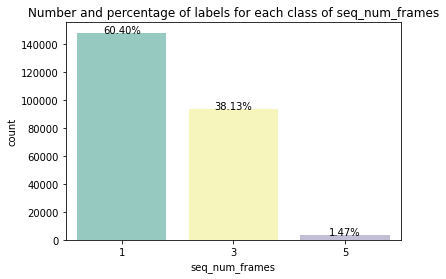

In [170]:
plot_classes('seq_num_frames', fs=3)

In [173]:
def draw_category_images(var,cols=3):
    categories = (df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(3*cols,3*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file_name']
            im = Image.open(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'cct_images/test/5900a2f8-23d2-11e8-a6a3-ec086b02610b.jpg'

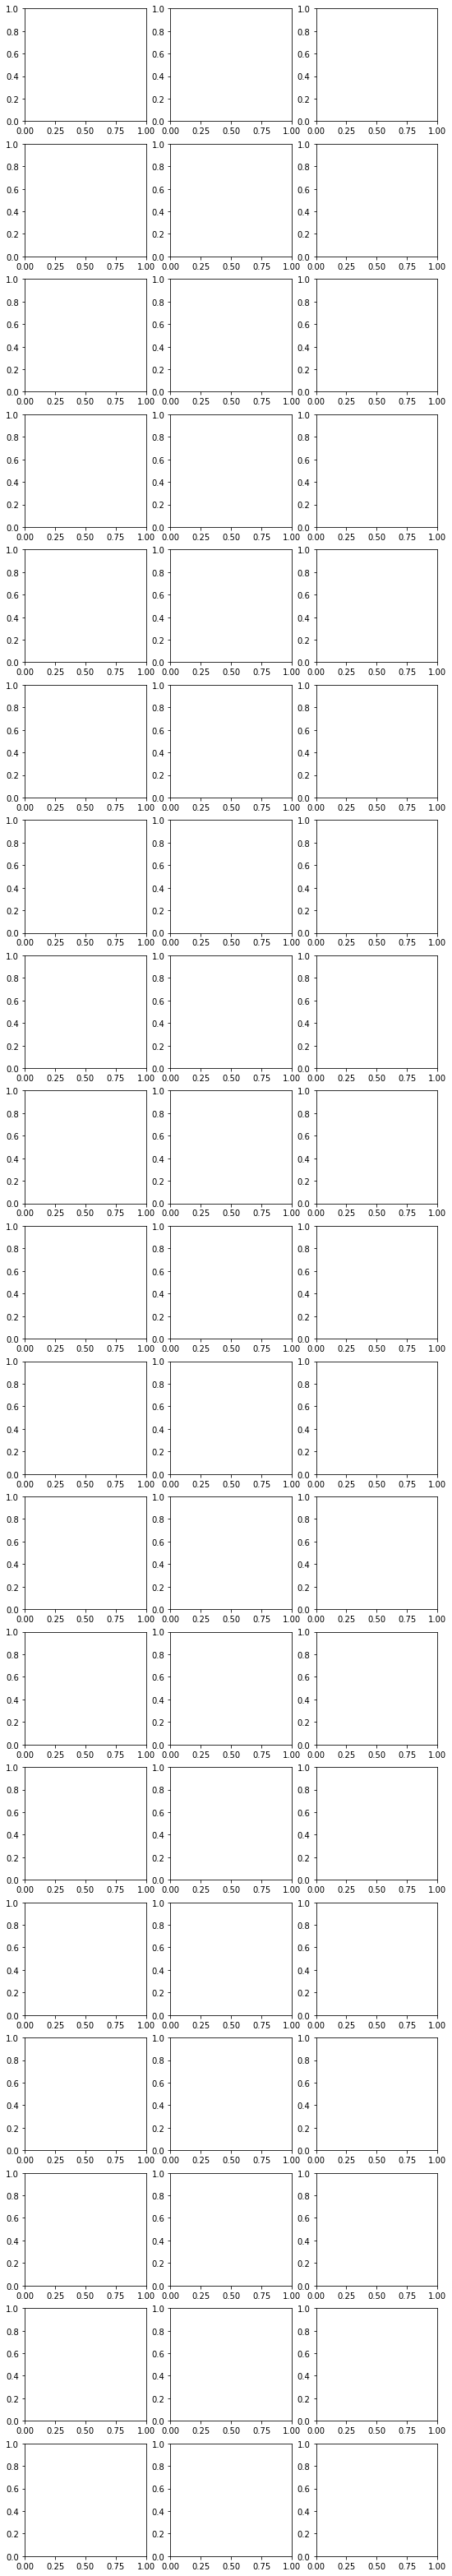

In [178]:
#when all photos will be downloaded then repeat
IMAGE_PATH = PATH
draw_category_images('label')



In [179]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

https://github.com/liuzhuang13/DenseNet  - about DenseNet - I downloaded also the paper

In [ ]:
model_densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(32,32,3)
)

